# Capstone Project - Toronto Airbnb and nearby venues

### Michaela Solomon
### Applied Data Science Capstone - IBM Coursera

## Table of contents
* [1.Introduction](#introduction)
* [2. Business problem](#bussiness)
* [3. Data sources and description](#data)
* [4. Methodology](#methodology)
  * [4.1 Data Collection](#datacollection)
  * [4.2vData preprocessing](#datapreprocessing)
  * [4.3 Feature Engineering](#featureengineering)
  * [4.4 Analysis](#analysis)
  * [4.5 Modeling and Visualization](#modeling)
* [5. Results and Discussion](#results)
* [6. Conclusion](#conclusion)

## 1. Introduction<a name="introduction"></a>

<p>Airbnb is an online marketplace where millions of hosts and travellers can create a free account so they can list their space or book accommodations anywhere in the world. It covers more than 100,000 cities and 220 countries worldwide.  Airbnb has been successful because it has managed to replace hotels as a traditional method of accommodation for travellers worldwide.</p><p>Being one of the most popular tourist destination in Canada, Toronto’s AirBnb market has been growing with an increased number of hosts joining and listing their homes for rent.</p>

## 2. Business Problem <a name="bussiness"></a>

<p>For this Capstone Project the business aim is to provide the travellers with relevant information about Airbnb offers and variety of restaurants to choose from in Toronto.</p><p>The listing price and amenities are an important factor in choosing a rental, but location is also important.  For travellers who love food it might be helpful to know in advance where to find a place to rent that has also has nearby restaurants of interest.<p>Using FourSquare API venues data to compare different neighbourhoods could be a good opportunity to choose, for example, an area with italian restaurants, aisian cusine, irish pub or a dessert shop.</p><p>Our main focus will be finding the top five food venue categories around <b>Airbnb</b> listings from the <b>Downtown Toronto</b> neighbourhoods.<p>

## 3. Data sources and description <a name="data"></a>

<p>In this project I used a few datasets as data sources:
    <ul>
       <li>List of Postal code of Canada: M provided by the <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">Wikipedia page</a> to get information about Toronto's postal codes, boroughs and neighbourhoods.</li>
        <li>Toronto's geographical coordinates available for download as a csv file from the Week3 course <a href="https://cocl.us/Geospatial_data">link</a></li>
        <li>Toronto's Airbnb listings provided by the<b></b> website: <a href="http://data.insideairbnb.com/canada/on/toronto/2021-01-02/data/listings.csv.gz">Inside Airbnb</a></li>
        <li>Foursquare API to retreive location and opther information about various venues in Toronto. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in Toronto and collected their names, categories and locations (latitude and longitude). 
            <a href="https://developer.foursquare.com/docs">From Foursquare API</a>, I retrieved the following for each venue:
            <ul><li>Name: The name of the venue.</li>
        <li>Category: The category type as defined by the API.</li>
        <li>Latitude: The latitude value of the venue.</li>
        <li>Longitude: The longitude value of the venue.</li></ul>
</li>
    </ul>

## 4. Methodology <a name='methodology'></a>

**Import** all necessary **libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#import geopandas as gpd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library for handling JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed geopy yet
import geocoder
from geopy.geocoders import Nominatim # library that convserts an address into longitude and latitude values
import requests # library to handle requests
from pandas import json_normalize # library to tranform JSON file into a pandas dataframe

import math
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncoment this line if you haven't installed it yet

# Folium and associated plugins for map rendering
import folium # map rendering library
from folium import Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

print('Libraries imported.')

Libraries imported.


In [2]:
# to make this notebook's output identical at every run
np.random.seed(42)

### 4.1 Data Collection <a name='datacollection'></a>

In the data collection stage we begin with collecting the required data for the city of Toront's postal codes, geographical coordinates, and Toronto's Airbnb listings.  
To collect data for postal codes, we scrape the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) in order to obtain the data that is in the table of postal codes and to transform it into a pandas  dataframe. We take data from the first table.  
Next, we read the [geospatial data csv file](http://cocl.us/Geospatial_datafile) that has the geographical coordinates of each postal code, and join both dataframes on `Postal Code` column.  
Finaly, we download and read into a pandas dataframe, the Toronto's airbnb listings from February 2021, which is available from [Inside Airbnb](http://data.insideairbnb.com/canada/on/toronto/2021-02-08/visualisations/listings.csv) website

**a. Scraping Toronto Neighborhoods Table from Wikipedia**

Dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs=pd.read_html(url, header=0)
print("number of tables on the web page: " + str(len(dfs)))

number of tables on the web page: 3


In [4]:
df_postal=dfs[0] # get the first table
df_postal.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [5]:
# check for null values
df_postal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Postal Code    180 non-null    object
 1   Borough        180 non-null    object
 2   Neighbourhood  180 non-null    object
dtypes: object(3)
memory usage: 4.3+ KB


**b. Add the geographical coordinates to the neighbourhoods table**  
Read the Geospatial_data csv file that has the geographical coordinates of each postal code, then join it with the neighbourhoods dataframe by the postal code column

In [6]:
df_latlong = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')

In [7]:
df_latlong.head() #inspect de first rows of the data

Latitude  Longitude
Postal Code                      
M1B          43.806686 -79.194353
M1C          43.784535 -79.160497
M1E          43.763573 -79.188711
M1G          43.770992 -79.216917
M1H          43.773136 -79.239476

In [8]:
df_latlong.info() #get a summary description of the data

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, M1B to M9W
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   103 non-null    float64
 1   Longitude  103 non-null    float64
dtypes: float64(2)
memory usage: 2.4+ KB


**c. Read the Toronto's Airbnb listings**

Read the csv file into a dataframe, and take a look at the headers and a few rows to better understand the data structure

In [9]:
listing_df=pd.read_csv('http://data.insideairbnb.com/canada/on/toronto/2021-02-08/visualisations/listings.csv')

In [10]:
listing_df.head()

id                                         name  host_id  \
0   1419              Beautiful home in amazing area!     1565   
1   8077           Downtown Harbourfront Private Room    22795   
2  23691              Queen Bedroom close to downtown    93825   
3  27423  Executive Studio Unit- Ideal for One Person   118124   
4  30931           Downtown Toronto - Waterview Condo    22795   

        host_name  neighbourhood_group                      neighbourhood  \
0       Alexandra                  NaN                    Little Portugal   
1  Kathie & Larry                  NaN  Waterfront Communities-The Island   
2   Yohan & Sarah                  NaN               Briar Hill-Belgravia   
3           Brent                  NaN                  Greenwood-Coxwell   
4  Kathie & Larry                  NaN  Waterfront Communities-The Island   

   latitude  longitude        room_type  price  minimum_nights  \
0  43.64617  -79.42451  Entire home/apt    469              28   
1  43.64105  -79.37628     Private room     96             180   
2  43.69602  -79.45468     Private room     72              28   
3  43.66890  -79.32592  Entire home/apt     45             365   
4  43.64151  -79.37643  Entire home/apt    128             180   

   number_of_reviews last_review  reviews_per_month  \
0                  7  2017-12-04               0.10   
1                169  2013-08-27               1.21   
2                217  2019-12-22               1.66   
3                 26  2011-08-30               0.20   
4                  1  2010-08-11               0.01   

   calculated_host_listings_count  availability_365  
0                               1                 0  
1                               2               365  
2                               2               362  
3                               1               346  
4                               2               365

In [11]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15832 non-null  int64  
 1   name                            15831 non-null  object 
 2   host_id                         15832 non-null  int64  
 3   host_name                       15816 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   15832 non-null  object 
 6   latitude                        15832 non-null  float64
 7   longitude                       15832 non-null  float64
 8   room_type                       15832 non-null  object 
 9   price                           15832 non-null  int64  
 10  minimum_nights                  15832 non-null  int64  
 11  number_of_reviews               15832 non-null  int64  
 12  last_review                     

A quick summary on the description of the data with info() shows that there are are missing values in some of the columns.

In [12]:
# checking for duplicates
listing_df.duplicated().sum() 

0

### 4.2 Data preprocessing <a name='datapreprocessing'></a>

Toronto's neighbourhoods dataframe will consist of three columns: PostalCode, Borough, and Neighborhood. 

Only the cells that have an assigned borough will be processed. Borough that is not assigned are ignored.
More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma.
If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [13]:
df_postal.drop(df_postal.index[df_postal['Borough'] == 'Not assigned'], inplace=True)

df_postal = df_postal.reset_index(drop=True)
df_postal.rename(columns={'Postal Code': 'PostalCode'}, inplace=True) # rename Postal Code with PostalCode
df_postal.head(3)

PostalCode           Borough              Neighbourhood
0        M3A        North York                  Parkwoods
1        M4A        North York           Victoria Village
2        M5A  Downtown Toronto  Regent Park, Harbourfront

**Checking for Postal Code duplicates and if exist the rows will be combined into one row with the neighborhoods separated with a comma**

In [14]:
df_postcode = df_postal.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

df_postcode.head(3)

PostalCode      Borough                           Neighbourhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill

In [15]:
df_postcode.shape

(103, 3)

**Check if a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.**

In [16]:
df_postcode = df_postcode.replace({'Neighbourhood':'Not assigned'}, df_postcode['Borough'])
df_postcode.head()

PostalCode      Borough                           Neighbourhood
0        M1B  Scarborough                          Malvern, Rouge
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek
2        M1E  Scarborough       Guildwood, Morningside, West Hill
3        M1G  Scarborough                                  Woburn
4        M1H  Scarborough                               Cedarbrae

**Join both, the Toronto's neighbourhoods postal codes dataframe and geospatial dataframe, on `Postal Code` column**

In [17]:
toronto_data = df_postcode.join(df_latlong, on='PostalCode')
toronto_data.head()

PostalCode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

**Because we are interested only in _Downtown Toronto_, so we select only the neighbourhoods from this borough.**  

Create a new dataframe that has the 'Borough' column value equal with 'Downtown Toronto'

In [18]:
downtown_data = toronto_data[toronto_data['Borough']=='Downtown Toronto'].reset_index(drop=True)
downtown_data

PostalCode           Borough  \
0         M4W  Downtown Toronto   
1         M4X  Downtown Toronto   
2         M4Y  Downtown Toronto   
3         M5A  Downtown Toronto   
4         M5B  Downtown Toronto   
5         M5C  Downtown Toronto   
6         M5E  Downtown Toronto   
7         M5G  Downtown Toronto   
8         M5H  Downtown Toronto   
9         M5J  Downtown Toronto   
10        M5K  Downtown Toronto   
11        M5L  Downtown Toronto   
12        M5S  Downtown Toronto   
13        M5T  Downtown Toronto   
14        M5V  Downtown Toronto   
15        M5W  Downtown Toronto   
16        M5X  Downtown Toronto   
17        M6G  Downtown Toronto   
18        M7A  Downtown Toronto   

                                        Neighbourhood   Latitude  Longitude  
0                                            Rosedale  43.679563 -79.377529  
1                         St. James Town, Cabbagetown  43.667967 -79.367675  
2                                Church and Wellesley  43.665860 -79.383160  
3                           Regent Park, Harbourfront  43.654260 -79.360636  
4                            Garden District, Ryerson  43.657162 -79.378937  
5                                      St. James Town  43.651494 -79.375418  
6                                         Berczy Park  43.644771 -79.373306  
7                                  Central Bay Street  43.657952 -79.387383  
8                            Richmond, Adelaide, King  43.650571 -79.384568  
9   Harbourfront East, Union Station, Toronto Islands  43.640816 -79.381752  
10           Toronto Dominion Centre, Design Exchange  43.647177 -79.381576  
11                     Commerce Court, Victoria Hotel  43.648198 -79.379817  
12                     University of Toronto, Harbord  43.662696 -79.400049  
13          Kensington Market, Chinatown, Grange Park  43.653206 -79.400049  
14  CN Tower, King and Spadina, Railway Lands, Har...  43.628947 -79.394420  
15                                     Stn A PO Boxes  43.646435 -79.374846  
16             First Canadian Place, Underground city  43.648429 -79.382280  
17                                           Christie  43.669542 -79.422564  
18        Queen's Park, Ontario Provincial Government  43.662301 -79.389494

In [116]:
print("There are {} neighbourhoods in Downtown Toronto area".format(downtown_data['Neighbourhood'].str.split(',').count()))

There are 19 neighbourhoods in Downtown Toronto area


#### From the airbnb listings I keep only the information that I need, so, I create a new dataframe with the following columns:  
'neighbourhood', 'latitude', 'longitude', 'room_type', 'price'

In [19]:
# create a new dataframe based on the selected columns
tobnb=listing_df[['neighbourhood', 'latitude', 'longitude', 'room_type', 'price']]

In [20]:
tobnb.head()

neighbourhood  latitude  longitude        room_type  \
0                    Little Portugal  43.64617  -79.42451  Entire home/apt   
1  Waterfront Communities-The Island  43.64105  -79.37628     Private room   
2               Briar Hill-Belgravia  43.69602  -79.45468     Private room   
3                  Greenwood-Coxwell  43.66890  -79.32592  Entire home/apt   
4  Waterfront Communities-The Island  43.64151  -79.37643  Entire home/apt   

   price  
0    469  
1     96  
2     72  
3     45  
4    128

In [21]:
print(tobnb.shape)
tobnb.info()

(15832, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  15832 non-null  object 
 1   latitude       15832 non-null  float64
 2   longitude      15832 non-null  float64
 3   room_type      15832 non-null  object 
 4   price          15832 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 618.6+ KB


The data frame has 15832 rows and 5 columns, also from the `info()` method we can see that there are no missing values.

In [22]:
# checking for null values

pd.isnull(tobnb).sum()  

neighbourhood    0
latitude         0
longitude        0
room_type        0
price            0
dtype: int64

In [23]:
# check for duplicate rows
tobnb.duplicated().sum()

99

In [24]:
# drop the duplicate rows
tobnb = tobnb.drop_duplicates()
tobnb.head()

neighbourhood  latitude  longitude        room_type  \
0                    Little Portugal  43.64617  -79.42451  Entire home/apt   
1  Waterfront Communities-The Island  43.64105  -79.37628     Private room   
2               Briar Hill-Belgravia  43.69602  -79.45468     Private room   
3                  Greenwood-Coxwell  43.66890  -79.32592  Entire home/apt   
4  Waterfront Communities-The Island  43.64151  -79.37643  Entire home/apt   

   price  
0    469  
1     96  
2     72  
3     45  
4    128

In [25]:
tobnb.duplicated().sum()

0

### 4.3 Feature Engineering <a name='featureengineering'></a>

#### Data engineering for Downtown Toronto neighbours dataframe

To get data about different venues in different neighbourhoods from Downtown Toronto, we use **Foursqare API**. This is a location data provider that helps to obtain information about all kind of venues and events within an area of interest. Such information includes: venue names, locations, menus and even photos.
For each neighbourhood, we have chosen the radius to be 500 meters.

The data retrieved from Foursquare contains information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue is as follows:

Neighbourhood : Name of the Neighbourhood

Neighbourhood Latitude : Latitude of the Neighbourhood

Neighbourhood Longitude : Longitude of the Neighbourhood

Venue : Name of the Venue

Venue Latitude : Latitude of Venue

Venue Longitude : Longitude of Venue

Venue Category : Category of Venue

**Defineing Foursquare Credentials, Version and Limit of the returned venues**

In [26]:
# Loading Foursquare credentials 
import yaml

with open("settings.yaml", 'r') as yamlfile:
    sett = yaml.safe_load(yamlfile)
    
CLIENT_ID = sett['CLIENT_ID']# your Foursquare ID
CLIENT_SECRET = sett['CLIENT_SECRET'] # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500 # define radius

#### Get coordinates of Downtown Toronto using geolocator and geopy libraries  
To obtain latitude and longitude, we import `Nominatim` module from `gelolocator`, define a `user agent` and pass the address to the `geocode()` method

In [27]:
# Coordinates of Downtown
address = 'Downtown Toronto, ON'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Downtown Toronto are 43.6563221, -79.3809161.


**Visualize the neighbourhoods of Downtown Toronto using _Folium_ library and Leaflet Map**  

Folium is a python library, we use it to draw an interactive leaflet map using coordinate data

In [28]:
map_toronto = folium.Map(location = [latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Borough'], downtown_data['Neighbourhood']):
    label='{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#318cc',
                       fill_opacity=0.7,
                       parse_html=False).add_to(map_toronto)

map_toronto

#### Explore Downtown Toronto venues
We create a function, `getNearbyVenues`, that makes a call to the **Foursqare API** to explore all restaurants from Downtown Toronto neighbourhoods.

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        restaurants='4d4b7105d754a06374d81259'
                
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            restaurants,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Retreiving nearby venues**

In [30]:
downtown_toronto_venues = getNearbyVenues(names=downtown_data['Neighbourhood'],
                                   latitudes=downtown_data['Latitude'],
                                   longitudes=downtown_data['Longitude']
                                  )

#### Get the size of the venues dataframe from Downtown Toronto

In [31]:
print("Downtown venues: ", downtown_toronto_venues.shape)
downtown_toronto_venues.head() # inspect the first rows

Downtown venues:  (1096, 7)


Neighbourhood  Neighbourhood Latitude  \
0                     Rosedale               43.679563   
1  St. James Town, Cabbagetown               43.667967   
2  St. James Town, Cabbagetown               43.667967   
3  St. James Town, Cabbagetown               43.667967   
4  St. James Town, Cabbagetown               43.667967   

   Neighbourhood Longitude           Venue  Venue Latitude  Venue Longitude  \
0               -79.377529     Saigonlotus       43.681281       -79.382401   
1               -79.367675     Cranberries       43.667843       -79.369407   
2               -79.367675  Kingyo Toronto       43.665895       -79.368415   
3               -79.367675      Murgatroid       43.667381       -79.369311   
4               -79.367675        F'Amelia       43.667536       -79.368613   

        Venue Category  
0  Japanese Restaurant  
1                Diner  
2  Japanese Restaurant  
3           Restaurant  
4   Italian Restaurant

**Check total number of venues**

In [32]:
print('Total venues: {}'.format(len(downtown_toronto_venues['Venue Category'].unique())))

Total venues: 80


**Check how many venues are in each neighbourhood**

In [33]:
downtown_toronto_venues.groupby('Neighbourhood').count().sort_values('Venue Category', ascending=False)

Neighbourhood Latitude  \
Neighbourhood                                                                
Toronto Dominion Centre, Design Exchange                               100   
Commerce Court, Victoria Hotel                                         100   
First Canadian Place, Underground city                                 100   
Stn A PO Boxes                                                          98   
Richmond, Adelaide, King                                                97   
Garden District, Ryerson                                                96   
Harbourfront East, Union Station, Toronto Islands                       82   
St. James Town                                                          68   
Central Bay Street                                                      67   
Church and Wellesley                                                    65   
Kensington Market, Chinatown, Grange Park                               55   
Berczy Park                                                             52   
University of Toronto, Harbord                                          29   
St. James Town, Cabbagetown                                             28   
Queen's Park, Ontario Provincial Government                             27   
Regent Park, Harbourfront                                               23   
Christie                                                                 6   
CN Tower, King and Spadina, Railway Lands, Harb...                       2   
Rosedale                                                                 1   

                                                    Neighbourhood Longitude  \
Neighbourhood                                                                 
Toronto Dominion Centre, Design Exchange                                100   
Commerce Court, Victoria Hotel                                          100   
First Canadian Place, Underground city                                  100   
Stn A PO Boxes                                                           98   
Richmond, Adelaide, King                                                 97   
Garden District, Ryerson                                                 96   
Harbourfront East, Union Station, Toronto Islands                        82   
St. James Town                                                           68   
Central Bay Street                                                       67   
Church and Wellesley                                                     65   
Kensington Market, Chinatown, Grange Park                                55   
Berczy Park                                                              52   
University of Toronto, Harbord                                           29   
St. James Town, Cabbagetown                                              28   
Queen's Park, Ontario Provincial Government                              27   
Regent Park, Harbourfront                                                23   
Christie                                                                  6   
CN Tower, King and Spadina, Railway Lands, Harb...                        2   
Rosedale                                                                  1   

                                                    Venue  Venue Latitude  \
Neighbourhood                                                               
Toronto Dominion Centre, Design Exchange              100             100   
Commerce Court, Victoria Hotel                        100             100   
First Canadian Place, Underground city                100             100   
Stn A PO Boxes                                         98              98   
Richmond, Adelaide, King                               97              97   
Garden District, Ryerson                               96              96   
Harbourfront East, Union Station, Toronto Islands      82              82   
St. James Town                                         68   

**Get the unique categories from venues**

In [34]:
unique_venue_categories=len(downtown_toronto_venues['Venue Category'].unique())
print('There are {} unique categories.'.format(unique_venue_categories))

There are 80 unique categories.


#### Data Engineering for Toronto's Airbnb dataframe

Looking at the airbnb listings, `tobnb`, **dataframe**, we observe that it does not contain a **borough column** for filtering the listings by the bourough. We are interested in getting the listings only from the Downtown borough.  

To handle this, we need to find the **postal code** for each listing, then join it with the `toronto_data` **dataframe** by the **Postal Code** column.  After this step, we'll be able to obtain the listings for the Downtown borough. 

**First step** is to select only the listings that are in the boundary area of Downtown Toronto, the **second step** is to find the postal code for each listing from the resulting dataframe, and the **last step** is to merge this dataframe with the neighbourhoods dataframe. 


Define a function using `geolocator.reverse()` method to obtain the postal codes from latitude and longitude.

In [35]:
# define a function to retreive the postal code for the Airbnb listings
def get_postalCode(lat, lon):
    postal_code=None
    while(postal_code is None):
        location = geolocator.reverse((lat, lon))
        if location.raw['address']['postcode']:
            postal_code=location.raw['address']['postcode'][0:3]
        else:
            postal_code=None
    return postal_code
            
get_postalCode(43.650571,-79.384568)

'M5H'

**Find the boundaries of Donwtown Toronto**

To do this, we have to find the `boundingbox` property that contains *south Latitude, north Latitude, west Longitude, east Longitude*

In [36]:
boundaries= geolocator.geocode('Downtown Toronto, Toronto, ON')

In [37]:
boundaries.raw['boundingbox']

['43.6463221', '43.6663221', '-79.3909161', '-79.3709161']

**Select the listings that have the coordinates between the boundaries of Downtown Toronto**

In [38]:
tobnb_downtown=tobnb[tobnb['latitude'].between(43.6463221,43.6663221,inclusive=True) & tobnb['longitude'].between(-79.3909161,-79.3709161,inclusive=True)]

In [39]:
tobnb_downtown.info() # get summary information of the new dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265 entries, 11 to 15831
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  1265 non-null   object 
 1   latitude       1265 non-null   float64
 2   longitude      1265 non-null   float64
 3   room_type      1265 non-null   object 
 4   price          1265 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 59.3+ KB


In [42]:
print("Downtown neighbours: {}".format(tobnb_downtown['neighbourhood'].unique()))

Downtown neighbours: ['Bay Street Corridor' 'Church-Yonge Corridor' 'Moss Park'
 'Cabbagetown-South St.James Town' 'Waterfront Communities-The Island'
 'Kensington-Chinatown']


**Find the postal code for each listing**

In [43]:
tobnb_downtown['PostalCode']=tobnb_downtown.apply(lambda x: get_postalCode(x['latitude'], x['longitude']), axis=1)

<ipython-input-43-312759540e54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tobnb_downtown['PostalCode']=tobnb_downtown.apply(lambda x: get_postalCode(x['latitude'], x['longitude']), axis=1)


In [44]:
tobnb_downtown.head()

neighbourhood  latitude  longitude        room_type  price  \
11    Bay Street Corridor  43.66103  -79.38340  Entire home/apt    120   
50  Church-Yonge Corridor  43.66168  -79.37937     Private room     70   
56              Moss Park  43.65574  -79.37216     Private room     60   
57              Moss Park  43.65574  -79.37216     Private room     72   
61  Church-Yonge Corridor  43.66050  -79.38057     Private room    170   

   PostalCode  
11        M4Y  
50        M5B  
56        M5A  
57        M5A  
61        M5B

**Merge the downtown listings with downtown neighbourhoods**

In [45]:
listings_conds=tobnb_downtown.merge(toronto_data, on='PostalCode', how='inner')

In [46]:
listings_conds.head()

neighbourhood  latitude  longitude        room_type  price  \
0    Bay Street Corridor  43.66103  -79.38340  Entire home/apt    120   
1    Bay Street Corridor  43.66420  -79.38465  Entire home/apt    198   
2    Bay Street Corridor  43.66455  -79.38533     Private room     73   
3  Church-Yonge Corridor  43.66445  -79.37991  Entire home/apt     64   
4  Church-Yonge Corridor  43.66483  -79.38388     Private room    100   

  PostalCode           Borough         Neighbourhood  Latitude  Longitude  
0        M4Y  Downtown Toronto  Church and Wellesley  43.66586  -79.38316  
1        M4Y  Downtown Toronto  Church and Wellesley  43.66586  -79.38316  
2        M4Y  Downtown Toronto  Church and Wellesley  43.66586  -79.38316  
3        M4Y  Downtown Toronto  Church and Wellesley  43.66586  -79.38316  
4        M4Y  Downtown Toronto  Church and Wellesley  43.66586  -79.38316

In [47]:
listings_conds.shape

(1265, 10)

In [48]:
listings_conds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265 entries, 0 to 1264
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  1265 non-null   object 
 1   latitude       1265 non-null   float64
 2   longitude      1265 non-null   float64
 3   room_type      1265 non-null   object 
 4   price          1265 non-null   int64  
 5   PostalCode     1265 non-null   object 
 6   Borough        1265 non-null   object 
 7   Neighbourhood  1265 non-null   object 
 8   Latitude       1265 non-null   float64
 9   Longitude      1265 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 108.7+ KB


In [49]:
# Check for duplicates
listings_conds.duplicated().sum()

0

In [50]:
# Rename some of the columns for easier identification
listings_conds.rename(columns={'neighbourhood': 'Listing Neighbourhood',
                              'latitude': 'Listing Latitude',
                              'longitude': 'Listing Longitude',
                             'room_type': 'Room Type',
                             'price': 'Price'}, inplace=True)

In [52]:
# Select ponly the columns of interest
listings_conds = listings_conds[['PostalCode', 'Borough','Neighbourhood','Listing Latitude','Listing Longitude','Room Type','Price']]

# display the first five rows
listings_conds.head()

PostalCode           Borough         Neighbourhood  Listing Latitude  \
0        M4Y  Downtown Toronto  Church and Wellesley          43.66103   
1        M4Y  Downtown Toronto  Church and Wellesley          43.66420   
2        M4Y  Downtown Toronto  Church and Wellesley          43.66455   
3        M4Y  Downtown Toronto  Church and Wellesley          43.66445   
4        M4Y  Downtown Toronto  Church and Wellesley          43.66483   

   Listing Longitude        Room Type  Price  
0          -79.38340  Entire home/apt    120  
1          -79.38465  Entire home/apt    198  
2          -79.38533     Private room     73  
3          -79.37991  Entire home/apt     64  
4          -79.38388     Private room    100

**Visualize the Airbnb listings from Downtown Toronto using Folium library**

In [53]:
listings_map = folium.Map(location = [latitude, longitude], zoom_start=13)
marker_cluster = MarkerCluster().add_to(listings_map)

# add markers to map
for lat, lng, neighbourhood, room_type, price, postal in zip(listings_conds['Listing Latitude'], listings_conds['Listing Longitude'], 
                                                     listings_conds['Neighbourhood'], listings_conds['Room Type'],
                                                             listings_conds['Price'], listings_conds['PostalCode']):
    label='neighbourhood: {}, room type: {},  price: {}, postal code: {}'.format(neighbourhood, room_type, price, postal)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#318cc',
                       fill_opacity=0.7,
                       parse_html=False).add_to(marker_cluster)

listings_map

#### Merge Downtown Toronto venues and listings dataframes by neighbourhood

In [54]:
# merge on neighborhoods
merged_df = listings_conds.merge(downtown_toronto_venues, on='Neighbourhood', how='inner')

# drop borough column 
merged_df.drop(['Borough'], axis=1, inplace=True)

merged_df.head()

PostalCode         Neighbourhood  Listing Latitude  Listing Longitude  \
0        M4Y  Church and Wellesley          43.66103           -79.3834   
1        M4Y  Church and Wellesley          43.66103           -79.3834   
2        M4Y  Church and Wellesley          43.66103           -79.3834   
3        M4Y  Church and Wellesley          43.66103           -79.3834   
4        M4Y  Church and Wellesley          43.66103           -79.3834   

         Room Type  Price  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Entire home/apt    120                43.66586                -79.38316   
1  Entire home/apt    120                43.66586                -79.38316   
2  Entire home/apt    120                43.66586                -79.38316   
3  Entire home/apt    120                43.66586                -79.38316   
4  Entire home/apt    120                43.66586                -79.38316   

                Venue  Venue Latitude  Venue Longitude      Venue Category  
0    Storm Crow Manor       43.666840       -79.381593    Theme Restaurant  
1            Fabarnak       43.666377       -79.380964          Restaurant  
2               Smith       43.666927       -79.381421      Breakfast Spot  
3  Sansotei Ramen 三草亭       43.666735       -79.385353    Ramen Restaurant  
4        Como En Casa       43.665160       -79.384796  Mexican Restaurant

In [55]:
merged_df['Neighbourhood'].nunique() # number of neighbourhoods

14

**Let's check the size of the resulting dataframe**

In [56]:
print(merged_df.shape)
print(merged_df.duplicated().sum())

(91889, 12)
0


### 4.4 Analysis <a name='analysis'></a>

##### Analyze nearby venues

In [57]:
# Number of unique Neighbours
merged_df['Neighbourhood'].nunique()

14

**Let's find out how many unique categories can be curated from all the returned venues**

In [58]:
print('There are {} uniques categories.'.format(len(merged_df['Venue Category'].unique())))

There are 77 uniques categories.


#### Analyse each neighbour  

#### One Hot Encoding

Since we are trying to find out what are the different kinds of venue categories present in each neighbourhood and then calculate the top five common venues, we use the One Hot Encoding to work with our categorical datatype of the venue categories. This helps to convert the categorical data into numeric data.

We perform one hot encoding and then calculate the mean of the grouped venue categories for each of the neighbourhoods.

In [59]:
# One hot encoding
toronto_onehot = pd.get_dummies(merged_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = merged_df['Neighbourhood']

# Move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

Neighbourhood  Afghan Restaurant  American Restaurant  \
0  Church and Wellesley                  0                    0   
1  Church and Wellesley                  0                    0   
2  Church and Wellesley                  0                    0   
3  Church and Wellesley                  0                    0   
4  Church and Wellesley                  0                    0   

   Arepa Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                 0                 0          0           0       0   
1                 0                 0          0           0       0   
2                 0                 0          0           0       0   
3                 0                 0          0           0       0   
4                 0                 0          0           0       0   

   Belgian Restaurant  Bistro  Brazilian Restaurant  Breakfast Spot  \
0                   0       0                     0               0   
1                   0       0                     0               0   
2                   0       0                     0               1   
3                   0       0                     0               0   
4                   0       0                     0               0   

   Burger Joint  Burrito Place  Café  Caribbean Restaurant  \
0             0              0     0                     0   
1             0              0     0                     0   
2             0              0     0                     0   
3             0              0     0                     0   
4             0              0     0                     0   

   Chinese Restaurant  Colombian Restaurant  Comfort Food Restaurant  \
0                   0                     0                        0   
1                   0                     0                        0   
2                   0                     0                        0   
3                   0                     0                        0   
4                   0                     0                        0   

   Creperie  Deli / Bodega  Diner  Doner Restaurant  Donut Shop  \
0         0              0      0                 0           0   
1         0              0      0                 0           0   
2         0              0      0                 0           0   
3         0              0      0                 0           0   
4         0              0      0                 0           0   

   Dumpling Restaurant  Eastern European Restaurant  Empanada Restaurant  \
0                    0                            0                    0   
1                    0                            0                    0   
2                    0                            0                    0   
3                    0                            0                    0   
4                    0                            0                    0   

   Ethiopian Restaurant  Falafel Restaurant  Fast Food Restaurant  \
0                     0                   0                     0   
1                     0                   0                     0   
2                     0                   0                     0   
3                     0                   0                     0   
4                     0                   0                     0   

   Filipino Restaurant  Fish & Chips Shop  Food Court  Food Truck  \
0                    0                  0           0           0   
1                    0                  0           0           0   
2                    0                  0           0           0   
3                    0                  0           0           0   
4                    0                  0           0           0   

   French Restaurant  Fried Chicken Joint  Gastropub  German Restaurant  \
0                  0                    0          0                  0   
1                  0                    0          0                  0   
2                  0      

**And let's examine the new dataframe size.**

In [60]:
toronto_onehot.shape

(91889, 78)

In [61]:
toronto_onehot['Neighbourhood'].nunique()

14

**Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [62]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

Neighbourhood  Afghan Restaurant  \
0                                         Berczy Park           0.000000   
1   CN Tower, King and Spadina, Railway Lands, Har...           0.000000   
2                                  Central Bay Street           0.000000   
3                                Church and Wellesley           0.015385   
4                      Commerce Court, Victoria Hotel           0.000000   
5              First Canadian Place, Underground city           0.000000   
6                            Garden District, Ryerson           0.000000   
7           Kensington Market, Chinatown, Grange Park           0.000000   
8                           Regent Park, Harbourfront           0.000000   
9                            Richmond, Adelaide, King           0.000000   
10                                     St. James Town           0.000000   
11                        St. James Town, Cabbagetown           0.000000   
12           Toronto Dominion Centre, Design Exchange           0.000000   
13                     University of Toronto, Harbord           0.000000   

    American Restaurant  Arepa Restaurant  Asian Restaurant  BBQ Joint  \
0              0.019231          0.000000          0.019231   0.000000   
1              0.500000          0.000000          0.000000   0.000000   
2              0.000000          0.000000          0.000000   0.000000   
3              0.015385          0.000000          0.000000   0.000000   
4              0.040000          0.000000          0.030000   0.000000   
5              0.050000          0.000000          0.030000   0.000000   
6              0.010417          0.000000          0.000000   0.000000   
7              0.000000          0.018182          0.000000   0.000000   
8              0.000000          0.000000          0.043478   0.000000   
9              0.041237          0.000000          0.061856   0.000000   
10             0.029412          0.000000          0.014706   0.014706   
11             0.035714          0.000000          0.000000   0.000000   
12             0.030000          0.000000          0.040000   0.000000   
13             0.000000          0.000000          0.000000   0.034483   

    Bagel Shop    Bakery  Belgian Restaurant    Bistro  Brazilian Restaurant  \
0     0.019231  0.076923            0.019231  0.038462              0.000000   
1     0.000000  0.000000            0.000000  0.000000              0.000000   
2     0.000000  0.000000            0.000000  0.000000              0.000000   
3     0.000000  0.000000            0.000000  0.000000              0.000000   
4     0.000000  0.040000            0.000000  0.000000              0.000000   
5     0.000000  0.040000            0.000000  0.000000              0.010000   
6     0.000000  0.031250            0.000000  0.000000              0.000000   
7     0.018182  0.072727            0.018182  0.018182              0.000000   
8     0.000000  0.086957            0.000000  0.000000              0.000000   
9     0.010309  0.030928            0.000000  0.000000              0.010309   
10    0.014706  0.044118            0.014706  0.014706              0.000000   
11    0.000000  0.071429            0.000000  0.000000              0.000000   
12    0.000000  0.040000            0.000000  0.010000              0.000000   
13    0.000000  0.068966            0.000000  0.000000              0.000000   

    Breakfast Spot  Burger Joint  Burrito Place      Café  \
0         0.019231      0.000000       0.000000  0.038462   
1         0.000000      0.000000       0.000000  0.000000   
2         0.000000      0.029851       0.000000  0.119403   
3         0.015385      0.046154       0.046154  0.030769   
4         0.040000      0.030000       0.010000  0.090000   
5         0.030000      0.030000       0.020000  0.100000   
6         0.010417      0.041667       0.010417  0.104167   
7         0.018182      0.036364       0.018182  0.145455   
8         0.086957      0.000000      

In [63]:
toronto_grouped.shape

(14, 78)

#### Top Venue Categories in the neighbourhoods

Now let's create the new dataframe and display the top 5 venue categories for each neighborhood.  
First, let's write a function to sort the venues in descending order.

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return(row_categories_sorted.index.values[0:num_top_venues])

In [65]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd', 'th', 'th']

# Create columns according to number of top venues categories
columns = ['Neighbourhood']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most common venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most common venue'.format(idx+1))
        
# Create a new dataframe 
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for idx in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[idx, 1:] = return_most_common_venues(toronto_grouped.iloc[idx, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighbourhood 1st Most common venue  \
0                                        Berczy Park                Bakery   
1  CN Tower, King and Spadina, Railway Lands, Har...   American Restaurant   
2                                 Central Bay Street                  Café   
3                               Church and Wellesley      Sushi Restaurant   
4                     Commerce Court, Victoria Hotel            Restaurant   

  2nd Most common venue      3rd Most common venue 4th Most common venue  \
0        Sandwich Place           Sushi Restaurant    Italian Restaurant   
1      Tapas Restaurant  Middle Eastern Restaurant           Pizza Place   
2        Sandwich Place         Chinese Restaurant   Japanese Restaurant   
3   Japanese Restaurant       Fast Food Restaurant           Pizza Place   
4                  Café         Italian Restaurant           Salad Place   

  5th Most common venue  
0            Restaurant  
1    Persian Restaurant  
2    Italian Restaurant  
3            Restaurant  
4        Sandwich Place

In [66]:
# Number of neighbourhoods
neighborhoods_venues_sorted['Neighbourhood'].nunique()

14

### 4.5 Modeling and Visualization<a name='modeling'></a>

#### Model building using K-means

In this part we cluster the venues categories by location of listings. Since this is analysis of unlabelled data, we will be using KMeans Clustering Machine learning algorithm to cluster similar neighbourhoods together. We will be going with the number of clusters as 5.

Run _k_-means to cluster the neighborhood into 5 clusters.

In [67]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=25, n_init=10).fit(toronto_grouped_clustering)

# cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 2, 2, 0, 0, 2, 4, 0, 0])

In [68]:
# create a dataframe of listings that includes latitude, longitude, neighbourhood, room type and price
listings = listings_conds[['Neighbourhood', 'Listing Latitude', 'Listing Longitude', 'Room Type', 'Price']]
listings.head()

Neighbourhood  Listing Latitude  Listing Longitude        Room Type  \
0  Church and Wellesley          43.66103          -79.38340  Entire home/apt   
1  Church and Wellesley          43.66420          -79.38465  Entire home/apt   
2  Church and Wellesley          43.66455          -79.38533     Private room   
3  Church and Wellesley          43.66445          -79.37991  Entire home/apt   
4  Church and Wellesley          43.66483          -79.38388     Private room   

   Price  
0    120  
1    198  
2     73  
3     64  
4    100

**Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.**

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge listings and clusters
toronto_merged = listings

# merge data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() 

Neighbourhood  Listing Latitude  Listing Longitude        Room Type  \
0  Church and Wellesley          43.66103          -79.38340  Entire home/apt   
1  Church and Wellesley          43.66420          -79.38465  Entire home/apt   
2  Church and Wellesley          43.66455          -79.38533     Private room   
3  Church and Wellesley          43.66445          -79.37991  Entire home/apt   
4  Church and Wellesley          43.66483          -79.38388     Private room   

   Price  Cluster Labels 1st Most common venue 2nd Most common venue  \
0    120               2      Sushi Restaurant   Japanese Restaurant   
1    198               2      Sushi Restaurant   Japanese Restaurant   
2     73               2      Sushi Restaurant   Japanese Restaurant   
3     64               2      Sushi Restaurant   Japanese Restaurant   
4    100               2      Sushi Restaurant   Japanese Restaurant   

  3rd Most common venue 4th Most common venue 5th Most common venue  
0  Fast Food Restaurant           Pizza Place            Restaurant  
1  Fast Food Restaurant           Pizza Place            Restaurant  
2  Fast Food Restaurant           Pizza Place            Restaurant  
3  Fast Food Restaurant           Pizza Place            Restaurant  
4  Fast Food Restaurant           Pizza Place            Restaurant

In [70]:
# checking for null values
pd.isnull(toronto_merged).sum() 

Neighbourhood            0
Listing Latitude         0
Listing Longitude        0
Room Type                0
Price                    0
Cluster Labels           0
1st Most common venue    0
2nd Most common venue    0
3rd Most common venue    0
4th Most common venue    0
5th Most common venue    0
dtype: int64

In [71]:
toronto_merged=toronto_merged.dropna()
toronto_merged.shape

(1265, 11)

Change the type to int32 for column Cluster Labels

In [72]:
toronto_merged = toronto_merged.astype({'Cluster Labels': 'int32'})
toronto_merged.head() 

Neighbourhood  Listing Latitude  Listing Longitude        Room Type  \
0  Church and Wellesley          43.66103          -79.38340  Entire home/apt   
1  Church and Wellesley          43.66420          -79.38465  Entire home/apt   
2  Church and Wellesley          43.66455          -79.38533     Private room   
3  Church and Wellesley          43.66445          -79.37991  Entire home/apt   
4  Church and Wellesley          43.66483          -79.38388     Private room   

   Price  Cluster Labels 1st Most common venue 2nd Most common venue  \
0    120               2      Sushi Restaurant   Japanese Restaurant   
1    198               2      Sushi Restaurant   Japanese Restaurant   
2     73               2      Sushi Restaurant   Japanese Restaurant   
3     64               2      Sushi Restaurant   Japanese Restaurant   
4    100               2      Sushi Restaurant   Japanese Restaurant   

  3rd Most common venue 4th Most common venue 5th Most common venue  
0  Fast Food Restaurant           Pizza Place            Restaurant  
1  Fast Food Restaurant           Pizza Place            Restaurant  
2  Fast Food Restaurant           Pizza Place            Restaurant  
3  Fast Food Restaurant           Pizza Place            Restaurant  
4  Fast Food Restaurant           Pizza Place            Restaurant

#### Create a map to visualize the resulting listing clusters

In [73]:
# create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors=[]
for lat, lon, poi, cluster, room, price in zip(toronto_merged['Listing Latitude'], 
                                               toronto_merged['Listing Longitude'], 
                                               toronto_merged['Neighbourhood'], 
                                               toronto_merged['Cluster Labels'],
                                               toronto_merged['Room Type'],
                                              toronto_merged['Price']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + 
                         ' (room type: ' + str(room) + ' price: ' + str(price) + ')', parse_html=True)
    folium.CircleMarker([lat, lon],
                       radius=5,
                       popup=label,
                       color=rainbow[cluster-1],
                       fill=True,
                       fill_color=rainbow[cluster-1],
                       fill_opacity=0.7).add_to(map_clusters)
map_clusters

#### Cluster Analysis

In [96]:
def venue_category_plot(col):
    plt.figure(figsize=(8,4))
    data=df[col].value_counts()
    sns.barplot(x=data.values, y=data.index,  data=df)
    plt.title('List of {}'.format(col), fontsize=14)
    plt.xlabel('Number of venues', fontsize=13)
    plt.xticks(rotation=0)
    plt.show

**cluster 0**

In [119]:
downtown0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]
downtown0.head()

Neighbourhood  Cluster Labels 1st Most common venue  \
439  Regent Park, Harbourfront               0                  Café   
440  Regent Park, Harbourfront               0                  Café   
441  Regent Park, Harbourfront               0                  Café   
442  Regent Park, Harbourfront               0                  Café   
443  Regent Park, Harbourfront               0                  Café   

    2nd Most common venue 3rd Most common venue 4th Most common venue  \
439            Restaurant                Bakery        Breakfast Spot   
440            Restaurant                Bakery        Breakfast Spot   
441            Restaurant                Bakery        Breakfast Spot   
442            Restaurant                Bakery        Breakfast Spot   
443            Restaurant                Bakery        Breakfast Spot   

    5th Most common venue  
439    Chinese Restaurant  
440    Chinese Restaurant  
441    Chinese Restaurant  
442    Chinese Restaurant  
443    Chinese Restaurant

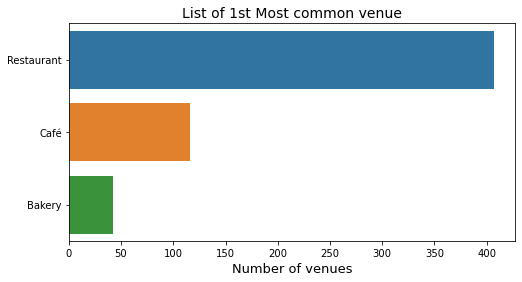

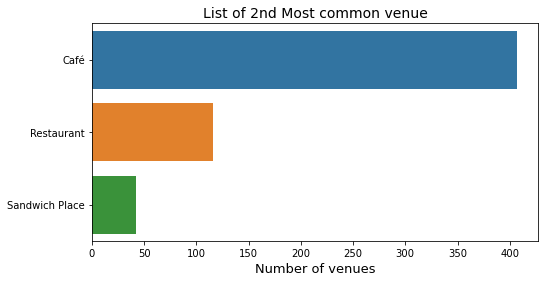

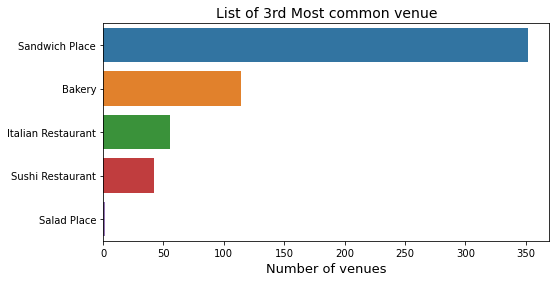

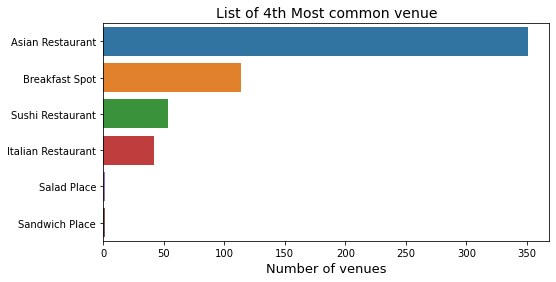

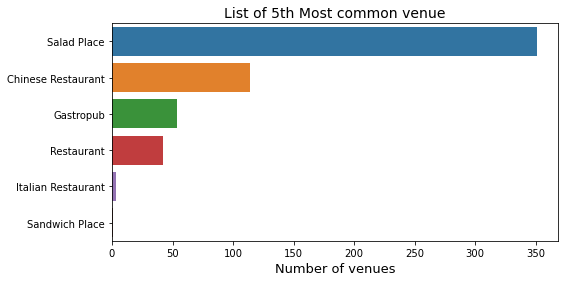

In [98]:
df = downtown0
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

**cluster 1**

In [99]:
downtown1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]
downtown1.head()

Neighbourhood  Cluster Labels  \
946  CN Tower, King and Spadina, Railway Lands, Har...               1   
947  CN Tower, King and Spadina, Railway Lands, Har...               1   
948  CN Tower, King and Spadina, Railway Lands, Har...               1   
949  CN Tower, King and Spadina, Railway Lands, Har...               1   
950  CN Tower, King and Spadina, Railway Lands, Har...               1   

    1st Most common venue 2nd Most common venue      3rd Most common venue  \
946   American Restaurant      Tapas Restaurant  Middle Eastern Restaurant   
947   American Restaurant      Tapas Restaurant  Middle Eastern Restaurant   
948   American Restaurant      Tapas Restaurant  Middle Eastern Restaurant   
949   American Restaurant      Tapas Restaurant  Middle Eastern Restaurant   
950   American Restaurant      Tapas Restaurant  Middle Eastern Restaurant   

    4th Most common venue 5th Most common venue  
946           Pizza Place    Persian Restaurant  
947           Pizza Place    Persian Restaurant  
948           Pizza Place    Persian Restaurant  
949           Pizza Place    Persian Restaurant  
950           Pizza Place    Persian Restaurant

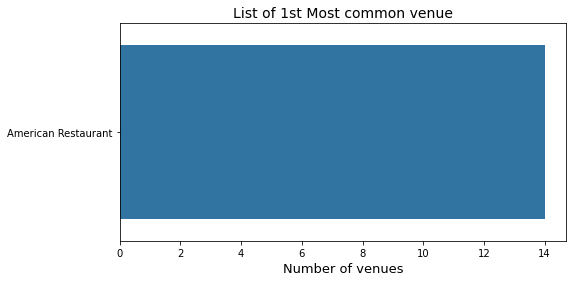

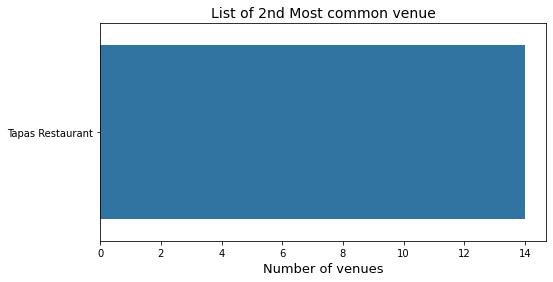

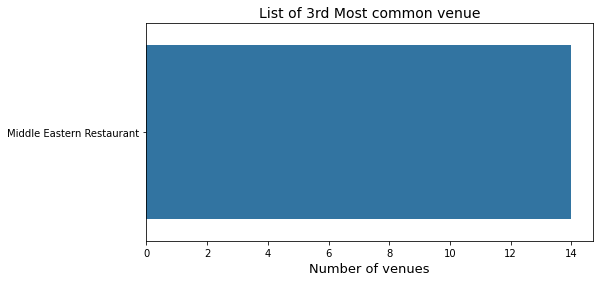

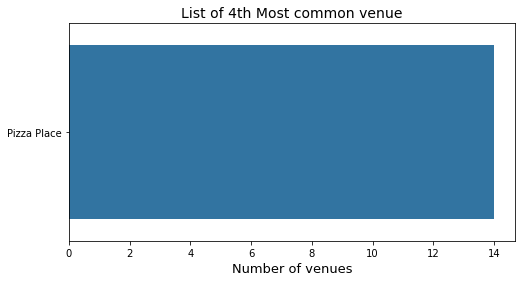

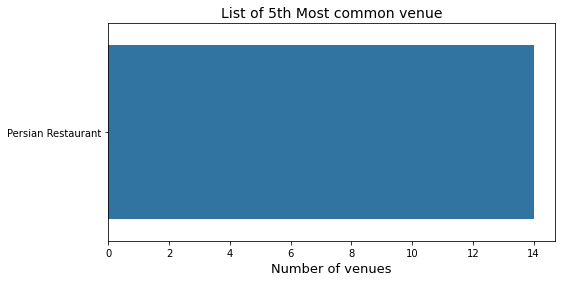

In [100]:
df = downtown1
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

**cluster 2**

In [101]:
downtown2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]
downtown2.head()

Neighbourhood  Cluster Labels 1st Most common venue  \
0  Church and Wellesley               2      Sushi Restaurant   
1  Church and Wellesley               2      Sushi Restaurant   
2  Church and Wellesley               2      Sushi Restaurant   
3  Church and Wellesley               2      Sushi Restaurant   
4  Church and Wellesley               2      Sushi Restaurant   

  2nd Most common venue 3rd Most common venue 4th Most common venue  \
0   Japanese Restaurant  Fast Food Restaurant           Pizza Place   
1   Japanese Restaurant  Fast Food Restaurant           Pizza Place   
2   Japanese Restaurant  Fast Food Restaurant           Pizza Place   
3   Japanese Restaurant  Fast Food Restaurant           Pizza Place   
4   Japanese Restaurant  Fast Food Restaurant           Pizza Place   

  5th Most common venue  
0            Restaurant  
1            Restaurant  
2            Restaurant  
3            Restaurant  
4            Restaurant

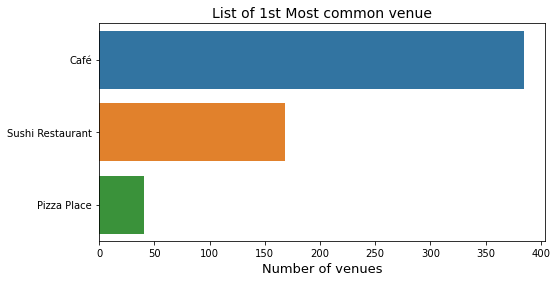

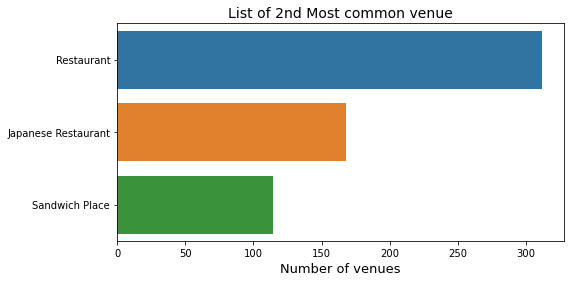

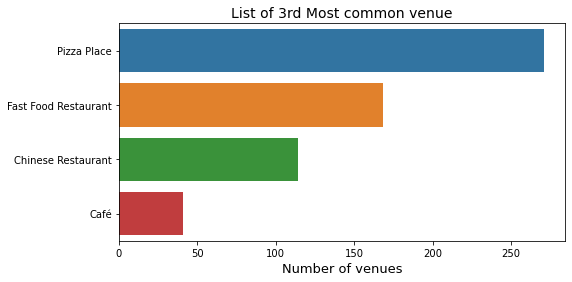

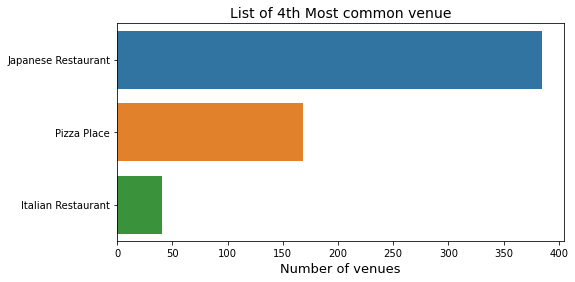

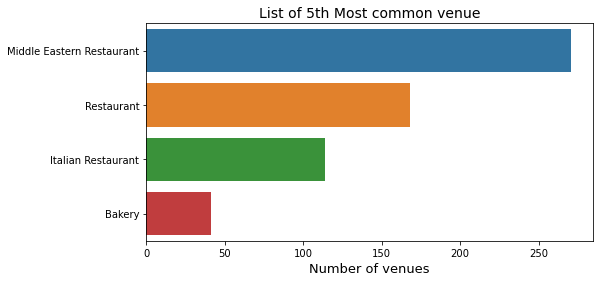

In [102]:
df = downtown2
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

**cluster 3**

In [120]:
downtown3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]
downtown3

Neighbourhood  Cluster Labels 1st Most common venue  \
1191  University of Toronto, Harbord               3                  Café   
1192  University of Toronto, Harbord               3                  Café   
1193  University of Toronto, Harbord               3                  Café   
1194  University of Toronto, Harbord               3                  Café   
1195  University of Toronto, Harbord               3                  Café   
1196  University of Toronto, Harbord               3                  Café   
1197  University of Toronto, Harbord               3                  Café   
1198  University of Toronto, Harbord               3                  Café   
1199  University of Toronto, Harbord               3                  Café   
1200  University of Toronto, Harbord               3                  Café   
1201  University of Toronto, Harbord               3                  Café   
1202  University of Toronto, Harbord               3                  Café   
1203  University of Toronto, Harbord               3                  Café   
1204  University of Toronto, Harbord               3                  Café   
1205  University of Toronto, Harbord               3                  Café   
1206  University of Toronto, Harbord               3                  Café   
1207  University of Toronto, Harbord               3                  Café   
1208  University of Toronto, Harbord               3                  Café   
1209  University of Toronto, Harbord               3                  Café   
1210  University of Toronto, Harbord               3                  Café   
1211  University of Toronto, Harbord               3                  Café   
1212  University of Toronto, Harbord               3                  Café   
1213  University of Toronto, Harbord               3                  Café   
1214  University of Toronto, Harbord               3                  Café   
1215  University of Toronto, Harbord               3                  Café   
1216  University of Toronto, Harbord               3                  Café   
1217  University of Toronto, Harbord               3                  Café   
1218  University of Toronto, Harbord               3                  Café   
1219  University of Toronto, Harbord               3                  Café   
1220  University of Toronto, Harbord               3                  Café   
1221  University of Toronto, Harbord               3                  Café   
1222  University of Toronto, Harbord               3                  Café   
1223  University of Toronto, Harbord               3                  Café   
1224  University of Toronto, Harbord               3                  Café   
1225  University of Toronto, Harbord               3                  Café   
1226  University of Toronto, Harbord               3                  Café   
1227  University of Toronto, Harbord               3                  Café   
1228  University of Toronto, Harbord               3                  Café   
1229  University of Toronto, Harbord               3                  Café   
1230  University of Toronto, Harbord               3                  Café   
1231  University of Toronto, Harbord               3                  Café   
1232  University of Toronto, Harbord               3                  Café   
1233  University of Toronto, Harbord               3                  Café   
1234  University of Toronto, Harbord               3                  Café   
1235  University of Toronto, Harbord               3                  Café   
1236  University of Toronto, Harbord               3                  Café   
1237  University of Toronto, Harbord               3                  Café   
1238  University of Toronto, Harbord               3                  Café   
1239  University of Toronto, Harbord               3                  Café   
1240  University of Toronto, Harbord               3                  Café   
1241  University of Toronto, Harbord         

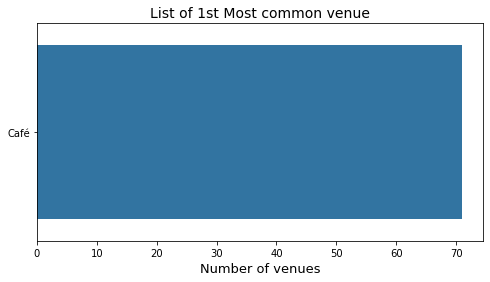

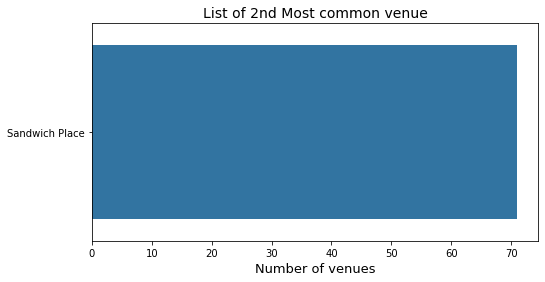

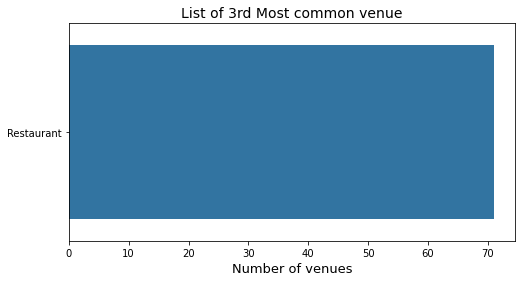

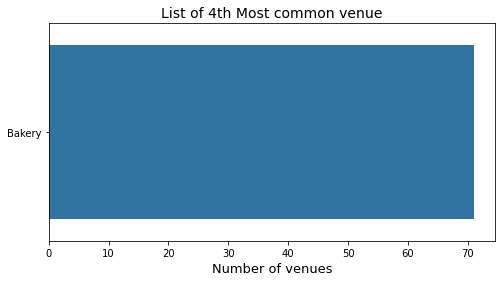

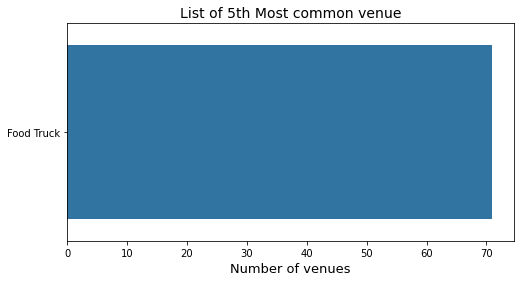

In [104]:
df = downtown3
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

**cluster 4**

In [105]:
downtown4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]
downtown4.head()

Neighbourhood  Cluster Labels  \
960  Kensington Market, Chinatown, Grange Park               4   
961  Kensington Market, Chinatown, Grange Park               4   
962  Kensington Market, Chinatown, Grange Park               4   
963  Kensington Market, Chinatown, Grange Park               4   
964  Kensington Market, Chinatown, Grange Park               4   

    1st Most common venue          2nd Most common venue  \
960                  Café  Vegetarian / Vegan Restaurant   
961                  Café  Vegetarian / Vegan Restaurant   
962                  Café  Vegetarian / Vegan Restaurant   
963                  Café  Vegetarian / Vegan Restaurant   
964                  Café  Vegetarian / Vegan Restaurant   

     3rd Most common venue 4th Most common venue 5th Most common venue  
960  Vietnamese Restaurant                Bakery    Mexican Restaurant  
961  Vietnamese Restaurant                Bakery    Mexican Restaurant  
962  Vietnamese Restaurant                Bakery    Mexican Restaurant  
963  Vietnamese Restaurant                Bakery    Mexican Restaurant  
964  Vietnamese Restaurant                Bakery    Mexican Restaurant

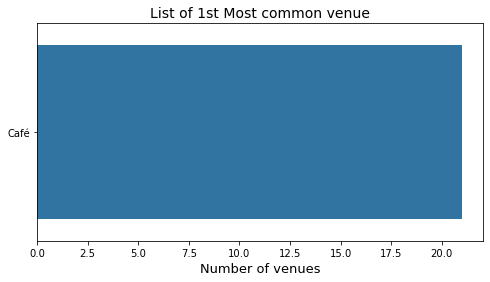

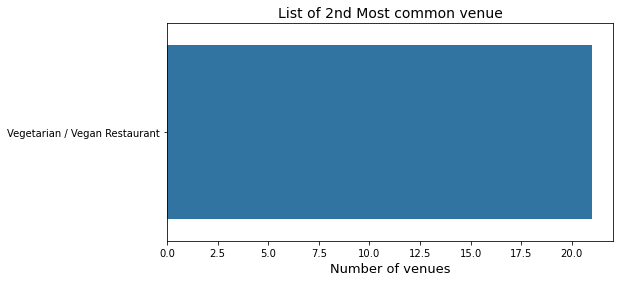

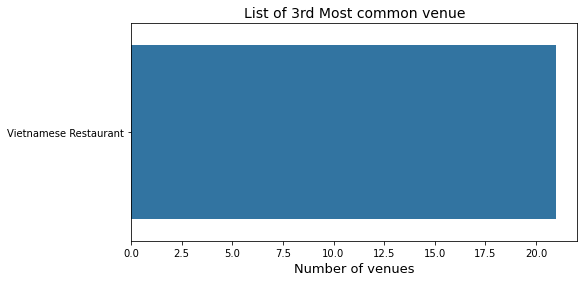

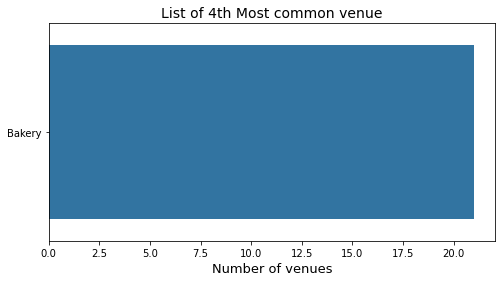

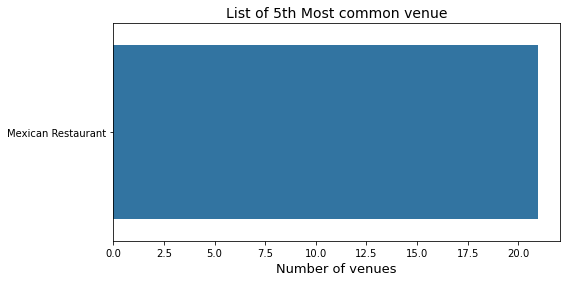

In [106]:
df = downtown4
for col in df.loc[:, '1st Most common venue':]:
    venue_category_plot(col)

#### Let's pick up cluster0 and create a map of all listings

In [108]:
# create map
map_listings1 = folium.Map(location=[toronto_merged['Listing Latitude'].mean(), 
                          toronto_merged['Listing Longitude'].mean()], zoom_start=14)
#marker_cluster1=MarkerCluster().add_to(map_listings1)
mc = MarkerCluster()
# show only listings in cluster 0
df_lists = toronto_merged[toronto_merged['Cluster Labels'] == 0]


# add markers to map
for lat, lon, room, price, first, second, third, fourth, fifth in zip(df_lists['Listing Latitude'], 
                                               df_lists['Listing Longitude'], 
                                               df_lists['Room Type'],
                                               df_lists['Price'],
                                                df_lists['1st Most common venue'],
                                                df_lists['2nd Most common venue'],
                                                df_lists['3rd Most common venue'],
                                                df_lists['4th Most common venue'],
                                                df_lists['5th Most common venue']):
    mc.add_child(folium.Marker(location=[lat, lon], popup='Room type: {}, Price: {}, Top 5 Nearby Venue Categories: {{ {}, {}, {}, {}, {} }}'.format(room, price, first, second, third, fourth, fifth)))
    
map_listings1.add_child(mc)

map_listings1

## 5. Results and Discussion<a name='results'></a>

**Results**

In the result section I can document all the findings from above clustering & visualization of the data. In this project, as the business problem stated, I started with identifying the Airbnb listing from Downtown Toronto and food places around them.

I looked into Toronto neighbourhoods and selected those of interest, then found the listings associated with Downtown area. I have used data from web resources like Wikipedia, geospatial coordinates of Toronto neighbourhoods, Toronto Airbnb listings, and Foursquare API, to set up a very realistic data-analysis scenario. 

The following findings are the result of the analysis:
  - there are **19** neighbourhoods in Downtown Toronto 
  - the total number of Airbnb listings in Toronto area is **15832** 
  - the number of Airbnb listing in Downtown area is **1265**
  - the number of neighbourhoods from Downtown area that have listings is **14**
  - the total number of Downtown venues is **80**
  - there are **77** unique food categories associated with these listings.

  There are five clusters of food categories. Plotting the number of top five number of food categories for each cluster we can see that:
  - cluster0 and cluster2 have more variety of restaurants like Italian, Asian, coffee places. 
  - cluster1 has a limited options of restaurant types, the most common is the American cuisine. 
  - most of the places in cluster3 are places where people can buy a coffee and have a sandwich
  - cluster4 most common places are also coffee shops and vegetarian/vegan cuisine 

If travellers are more interested in fancy restaurants they can choose listings from cluster0 or cluster2. If they want to eat local, the cluster1 is a good option to choose from. If they like to enjoy a cup of coffee and have a snack, cluster3 is a good option, and finally if they are more into vegetarian cuisine, they can opt for cluster4.

**Discussion**

The project is a good practice opportunity in terms of working with Foursquare API, Folium library, and clustering method in machine learning. The K-Means algorithm is an unsupervised learning technique and simple algorithm capable of clustering the dataset very quickly and efficiently, often in just a few iterations.

Choosing different number of clusters (n_clusters) effectively affects the result.

The project approaches the k-means method to clustering as the end goal. The project does not intentionally find the best k in terms of k-means.

## 6. Conclusion <a name='conclusion'></a>

In this project, I've got the chance to work on a business problem like a real data scientist would do. I was able to find locations of places to rent in Downtown Toronto Airbnb where are also near food places of interest using Foursquare API, Folium, and machine learning approaches.

I used many python libraries to fetch the data, to manipulate, analyses and visualize the content. I made use of Foursquare API to explore the nearby venues of Downtown Toronto, then got data from Wikipedia and visualized using matplotlib plotting library. I also applied machine learning technique to predict the output given the data and used Folium to visualize it on a map.

I obtained lists of the most common food places in Downtown Toronto for each cluster.

I picked a cluster to visualize on a map the listings, and for each one, to show the top 5 venues available.

Also, some of the drawbacks or areas of improvements shows us that this analysis can further be improved with the help of more data and different machine learning technique. Similarly we can use this project to analysis any scenario such finding venues from different venue categories such as Arts & Entertainment, Outdoors & Recreation, or even College & University.
